# Расчет насыщенного пара через штуцер:
### 1. Расчет расхода в зависимости от давления на выходе, при фиксированном давлении на входе
### 2. Расчет давления на входе в зависимости от расхода, при разных давлениях на выходе
### 3. Расчет давления на выходе в зависимости от давления на входе, при разных расходах
### 4. Расчет перепада давления в зависимости от расхода

Расчеты ведутся на основе методики Chien, Sze-Foo, Texaco Inc. и Schrodt, J.L.G., Texaco Inc.

Статья SPE https://www.onepetro.org/journal-paper/SPE-24832-PA, в основе которой лежит книга Flow measurement engineering handbook (автор Richard W. Miller), а именно глава "THEORETICAL FLOW-RATE EQUAТIONS" стр. 377-397.

Статья не рассматривает вместе критический и докритический режим, поэтому в расчетах нет границы перехода и используется только модель докритического режима.

Эксперименты проводились в трубе диаметром 49.276 мм, при давлении пара от 28 до 55 атм, сухости пара от 19 до 95%, массовом расходе от 900 до 6800 кг/час, диаметр отверстия составлял 6.35 мм. 

Эксперименты показали ошибку не более, чем 4.75%.

В статье не говорится о возможности использования модели для ГЖС или других жидкостей или газов кроме насыщенного пара.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sympy import *
import scipy.optimize as opt
import logging
from pyXSteam.XSteam import XSteam
steamTable = XSteam(XSteam.UNIT_SYSTEM_MKS)

In [2]:
def wchoke_kghr(p1_atm, p2_atm,d0_mm=5):
    
    """
    расчет расхода насыщенного пара через штуцер по методике Чиена (Миллера)
    p1_atm - давление на входе в штуцер, атм
    p2_atm - давление на выходе из штуцера, атм
    d0_mm - диаметр штуцера, мм
    """
    d1_mm=100 # диаметр трубы, мм
    C0 =0.8 # коэффициент разряда штуцера
    Y1=0.89487 # коэффициент расширения пара,считаюn его постоянным,зависит от давлений и диаметров
    A=0.99998 # эмпирические коэффициенты, рассчитаны из графиков по статье
    B=1.38
    X=0 # сухость пара
    vfg_m3kg=steamTable.vV_p(p1_atm) # удельный объем пара при заданном давлении м3/кг
    vf_m3kg=steamTable.vL_p(p1_atm) # удельный объем жидкости при заданном давлении м3/кг
    vexp_m3kg=A*vfg_m3kg*X**B+vf_m3kg #удельный объем смеси м3/кг
    ro_kgm3=1/vexp_m3kg #плотность смеси кг/м3
    beta=d0_mm/d1_mm
    f_atm=p1_atm-p2_atm 
    f_kPa=f_atm*100
    w_kgsec=3.512407*10**(-5)*C0*Y1*d0_mm**2*(f_kPa*ro_kgm3)**0.5/(1-beta**4)**0.5
    w_kghr=w_kgsec*3600
    return w_kghr

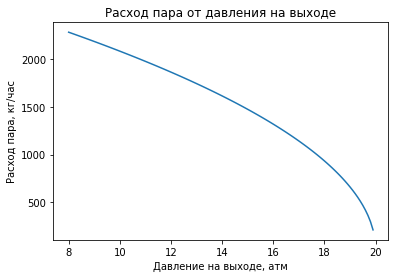

In [3]:
'Построение графика "Расход пара от давления на выходе при фиксированном давлении на входе"'
p1_atm=20 #давление на входе, атм
p2_atm_a = np.arange(8,p1_atm,0.1) # давление на выходе, для которых расчитывается расход пара
q=np.array([])
for p2 in p2_atm_a:
    w=wchoke_kghr(p1_atm, p2)
    q=np.append(q,w)    
plt.plot(p2_atm_a,q)
plt.title('Расход пара от давления на выходе')
plt.ylabel('Расход пара, кг/час')
plt.xlabel('Давление на выходе, атм')
plt.show()

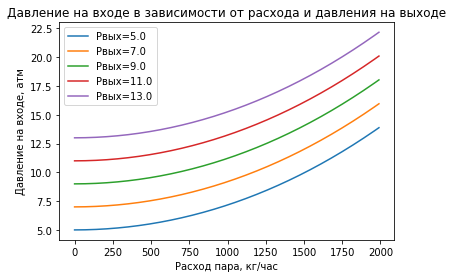

In [5]:
'Построение графика "Давление на входе в зависимости от расхода и давления на выходе"'
'Давление на входе считается с помощью функции opt.fsolve '
p2_atm_a= np.arange(5,15,2)  #давление на выходе для которых расчитываются давления на входе в зависимости от расхода, атм
for p2_atm in p2_atm_a:
    i_a=np.arange(0,2000,10) # расход, кг/час для которого находится давление на входе
    for i in i_a:
        def w2(p1_atm):
            return wchoke_kghr(p1_atm,p2_atm)-i
        def p1_atm(w2):
            p1_atm=opt.fsolve(w2,p2_atm)
            return p1_atm
    q=np.array([])
    for i in i_a:
        p1=p1_atm(w2)
        q=np.append(q,p1)
    plt.plot(i_a,q,label='Рвых=%1.1f'%p2_atm)
plt.title('Давление на входе в зависимости от расхода и давления на выходе')
plt.xlabel('Расход пара, кг/час')
plt.ylabel('Давление на входе, атм')   
plt.legend()
plt.show() 

In [7]:
def p2_atm( w_kghr, p1_atm, d0_mm=5):
    """
    расчет давления на выходе от давления на входе при разных расходах
    p1_atm - давление на входе в штуцер, атм
    w_kghr - расход пара, кг/час
    d0_mm - диаметр штуцера, мм
    """
    d1_mm=100 # диаметр трубы
    C0 =0.8 # коэффициент разряда штуцера
    Y1=0.89487 # коэффициент расширения пара
    A=0.99998 # эмпирические коэффициенты, рассчитаны из графиков по статье
    B=1.38
    X=0 # сухость пара
    vfg_m3kg=steamTable.vV_p(p1_atm) # удельный объем пара при заданном давлении м3/кг
    vf_m3kg=steamTable.vL_p(p1_atm) # удельный объем жидкости при заданном давлении м3/кг
    vexp_m3kg=A*vfg_m3kg*X**B+vf_m3kg #удельный объем смеси м3/кг
    ro_kgm3=1/vexp_m3kg #плотность смеси кг/м3
    beta=d0_mm/d1_mm
    w_kgsec=w_kghr/3600
    f_kPa=w_kgsec**2*(1-beta**4)*10**10/(12.337*C0**2*Y1**2*d0_mm**4*ro_kgm3)
    p2_atm=p1_atm-f_kPa/100
    return p2_atm

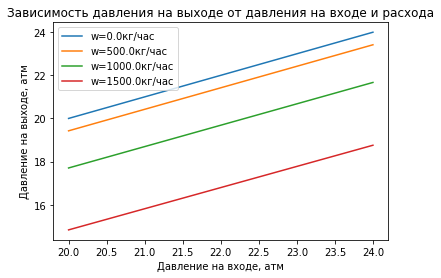

In [9]:
'Построение графика "Давление на выходе в зависимости от расхода и давления на входе"'
wi_a=np.arange(0,2000,500) #расход, кг/час для которого находится давление на выходе
for wi_kghr in wi_a:
    p1_atm_a = np.arange(20,25,1) #давление на входе для которых расчитываются давления на выходе в зависимости от расхода, атм
    q1=np.array([])
    for p1 in p1_atm_a:
        p2=p2_atm(wi_kghr, p1)
        q1=np.append(q1,p2) 
    plt.plot(p1_atm_a,q1, label='w=%1.1f'%wi_kghr+ 'кг/час')
plt.title('Зависимость давления на выходе от давления на входе и расхода')
plt.xlabel('Давление на входе, атм')
plt.ylabel('Давление на выходе, атм')
plt.legend()
plt.show() 

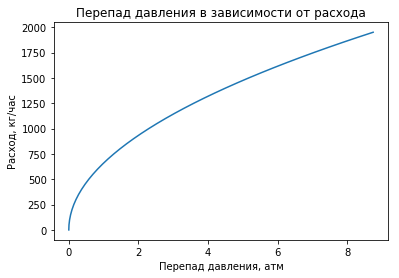

In [10]:
'Построение графика "Перепад давления в зависимости от расхода"'
'Разница давлений считается с помощью функции opt.fsolve '
i_a=np.arange(0,2000,50) # расход, кг/час для которого находится перепад давлений
p1_atm=20 # фиксированное давление на входе, атм
for i in i_a:
    def w2(f):
        return wchoke_kghr(p1_atm,p1_atm-f)-i
    def f(w2):
        f=opt.fsolve(w2,0)
        return f
    q=np.array([])
    for i in i_a:
        f1=f(w2)
        q=np.append(q,f1)
plt.plot(q, i_a)
plt.title('Перепад давления в зависимости от расхода')
plt.ylabel('Расход, кг/час')
plt.xlabel('Перепад давления, атм')   
plt.show() 